### Import the needed modules

In [70]:
from models import *
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Bring and plot your EIS data here
Check if its has come as it is

your first column should contain the frequency values, second column should contain the real part of the impedance, the third column should contain the imaginary part of the impedance

array([<Axes: xlabel='f [Hz]', ylabel='$|Z(\\omega)|$ $[Ohms]$'>,
       <Axes: xlabel='f [Hz]', ylabel='$-\\phi_Z(\\omega)$ $[^o]$'>],
      dtype=object)

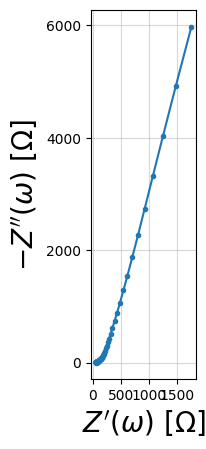

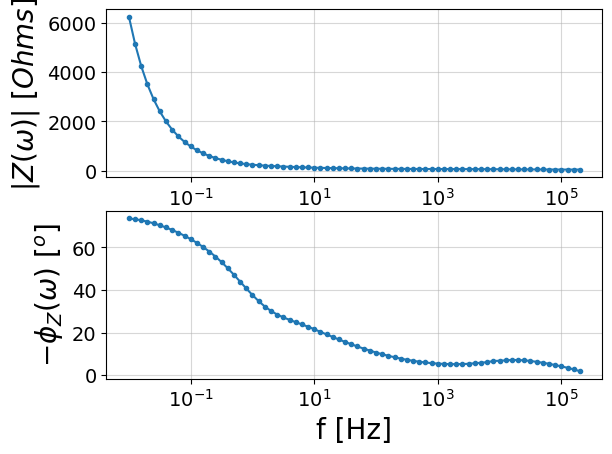

In [73]:
freq, zdata = readBioLogic("exampleData.mpt")
freq1, zdata1 = readCSV("hello.csv")

plot_nyquist(zdata)
plot_bode(freq,zdata)

### Provide the frequency range in which you want to fit

Implement it later

In [ ]:
f_range=

#### Choose the inhomogenity profile of tortuosity and provide the initial guesses for the parameters
The following profiles are available

1. Uniform tortuosity
2. Two-Step inhomogenity in tortuosity
3. Three-Step
4. Linearly varying toruosity
5. Inverse-Linear

You can also select all the profiles at once and see which one fits better:
using the ...........(to be conti.)


In [74]:
#initial guesses for the TLM
R1=500
R2=100
Q=1e-6
delta1=0.3
R3=500
delta2=0.3
alpha=0.98

#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

In [ ]:
#---uncomment the line below for fitting the uniform tortuosity profile---
# cuni=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl],circuit="TLMuni-R_1-p(R_2,Q_1)")

ctwo=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl],circuit="TLMtwo-R_1-p(R_2,Q_1)")

# cthree=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl],circuit="TLMthree-R_1-p(R_2,Q_1)")

# clin=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl],circuit="TLMlin-R_1-p(R_2,Q_1)")

# cilin=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl],circuit="TLMilin-R_1-p(R_2,Q_1)")

cmodel=ctwo

In [ ]:
freq=np.logspace(f_low,f_high,100)
zmodel=cmodel.predict(freq)

### Choose weighing method for the fitting

In [43]:
wt="unit"
#wt="mod"
#wt="prop"

In [55]:

cuni.fit(impedance=zout,frequencies=f,bounds=[(0,0,0.5),(np.inf,np.inf,1)])
ctwo.fit(impedance=zout,frequencies=f,bounds=[(0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
#cthree.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
#clin.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])
#cilin.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])




Circuit string: TLMthree
Fit: True

Initial guesses:
  TLMthree_0 = 5.00e+02 [Ohm]
  TLMthree_1 = 5.00e-04 [Ohm F]
  TLMthree_2 = 1.00e-04 [Ohm F]
  TLMthree_3 = 5.00e-04 []
  TLMthree_4 = 3.00e-01 []
  TLMthree_5 = 3.00e-01 []
  TLMthree_6 = 9.80e-01 []

Fit parameters:
  TLMthree_0 = 5.00e+02  (+/- 3.72e-09) [Ohm]
  TLMthree_1 = 5.00e-04  (+/- 3.87e-15) [Ohm F]
  TLMthree_2 = 8.23e-05  (+/- 5.13e-08) [Ohm F]
  TLMthree_3 = 2.08e-04  (+/- 3.17e-07) []
  TLMthree_4 = 3.06e-01  (+/- 1.76e-05) []
  TLMthree_5 = 4.25e-01  (+/- 1.91e-05) []
  TLMthree_6 = 9.80e-01  (+/- 2.33e-13) []



### Notes
Change the print function to directly print name of the parameters


In [45]:
# def profile_plotter(circuit,ax):
    
#     if(circuit._is_fit()):
#         param=circuit.parameters_
#     else:
#         param=circuit.initial_guess
#     profile=circuit.circuit

#     ax1=ax
#     if(profile=="TLMtwo"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        delta1=param[3]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        ax1.plot([0,delta1,delta1,1],[R1,R1,R2,R2],linewidth=2,color="red",label="Actual")
    
#     if(profile=="TLMthree"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R3Q=param[3]
#        delta1=param[4]
#        delta2=param[5]
#        Q=R1Q/R1
#        R2=R2Q/Q
#        R3=R3Q/Q
#        ax1.plot([0,delta1,delta1,delta2+delta1,delta2+delta1,1],[R1,R1,R2,R2,R3,R3],linewidth=2,color="blue",label="Actual")

#     if(profile=="TLMlin" or profile=="TLMlinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="green",label="Fit (clean)")

#     if(profile=="TLMilin" or profile=="TLMilinzert"):
#        R1=param[0]
#        R1Q=param[1]
#        R2Q=param[2]
#        R2=R1*R2Q/R1Q
#        ax1.plot([0,1],[R1,R2],linewidth=2,color="blue",label="Fit (noise)")
#        def give_ilin_R(r1,r2,delta):
#         return 1/(1/r1+(1/r2-1/r1)*delta)
#        dlt=np.linspace(0,1,50)
#        ax1.plot(dlt,give_ilin_R(R1,R2,dlt),linewidth=2,color="grey",label="Fitted 1")

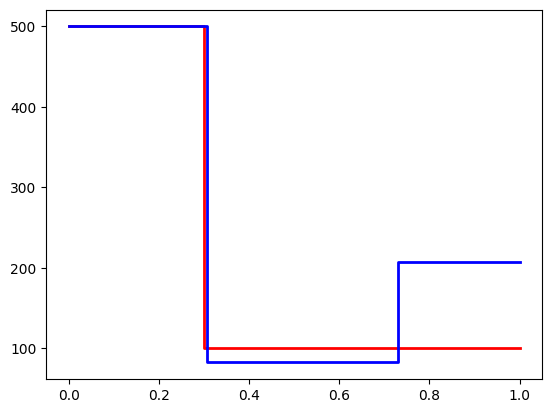

In [53]:
from models import *
fig, ax= plt.subplots()
profile_plotter(circuit=c1,ax=ax)
profile_plotter(circuit=cthree,ax=ax)
plt.show()
# print(cthree)
# ztwo1=c1.predict(frequencies=f)
# zthree1=cthree.predict(frequencies=f)
# fig, ax1 = plt.subplots()
# models.error_plotter(f,ztwo1,zthree1,ax=ax1)